In [ ]:
# Install PySpark
!pip install pyspark

# Install matplotlib for visualizations
!pip install matplotlib

# Install scikit-learn for metrics
!pip install scikit-learn


In [ ]:
!pip install rich

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [4]:
# Create Spark session
spark = SparkSession.builder.appName('ml-cls').getOrCreate()


In [5]:
# Load dataset
df = spark.read.csv('/content/HeartDisease.csv', header=True, inferSchema=True)

# Show schema of the DataFrame
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [6]:
# Drop non-relevant columns
df = df.drop('sex', 'cp', 'slope')

In [7]:
X = df.drop('target')  # Remove label from the features

In [8]:
# Feature engineering: VectorAssembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=X.columns, outputCol='features')
transformed_data = assembler.transform(df)

In [9]:
# Show transformed data
transformed_data.show(5, truncate=False)

+---+--------+----+---+-------+-------+-----+-------+---+----+------+------------------------------------------------+
|age|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|ca |thal|target|features                                        |
+---+--------+----+---+-------+-------+-----+-------+---+----+------+------------------------------------------------+
|52 |125     |212 |0  |1      |168    |0    |1.0    |2  |3   |0     |[52.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,3.0]|
|53 |140     |203 |1  |0      |155    |1    |3.1    |0  |3   |0     |[53.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,3.0]|
|70 |145     |174 |0  |1      |125    |1    |2.6    |0  |3   |0     |[70.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,3.0]|
|61 |148     |203 |0  |1      |161    |0    |0.0    |1  |3   |0     |[61.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,1.0,3.0]|
|62 |138     |294 |1  |1      |106    |0    |1.9    |3  |2   |0     |[62.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,3.0,2.0]|
+---+--------+----+---+-------+-------+-----+---

In [10]:
from rich.console import Console
# Initialize a Console for rich formatting
console = Console()

In [13]:
# Function to evaluate the model with different train-test splits
def evaluate_model(test_ratio, train_ratio):
    print('#################################################################################################################################')
    console.print(
        f"[bold underline]This is for {int(test_ratio * 100)}% Test and {int(train_ratio * 100)}% Train[/bold underline]",
        justify="center",
        style="blue"
    )
    print('#################################################################################################################################')
    # Split the data into train and test sets
    (X_train, X_test) = transformed_data.randomSplit([train_ratio, test_ratio])

    # Initialize Logistic Regression model
    lr = LogisticRegression(featuresCol='features', labelCol='target')

    # Train the model
    lr_model = lr.fit(X_train)

    # Make predictions on the test data
    predictions = lr_model.transform(X_test)

    # Show some predictions
    predictions.select('age', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'thal', 'prediction').show(5)

    # Group by the 'target' and 'prediction' columns to see the counts
    predictions.groupBy('target', 'prediction').count().show()

    # Extract true labels and predicted labels as lists
    y_true = predictions.select('target').rdd.flatMap(list).collect()
    y_pred = predictions.select('prediction').rdd.flatMap(list).collect()

    # Calculate confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)

    # Print confusion matrix
    print(f"Confusion Matrix (Test ratio {test_ratio}):")
    print(cm)

    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)

    # Annotate each cell in the confusion matrix
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

    # Calculate metrics from confusion matrix
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)

    # Print metrics
    print(f'Metrics computed from a confusion matrix (Test ratio {test_ratio}):')
    print("Accuracy:\t", accuracy)
    print("Classification Error:", 1 - accuracy)
    print("Sensitivity/Recall:\t", recall)
    print("Specificity:\t", specificity)
    print("Precision:\t", precision)
    print("False Positive Rate:", 1 - TN / (TN + FP))

#################################################################################################################################


                                        This is for 20% Test and 80% Train                                         

#################################################################################################################################
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
|age|trestbps|chol|fbs|restecg|thalach|exang|oldpeak| ca|thal|prediction|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
| 29|     130| 204|  0|      0|    202|    0|    0.0|  0|   2|       1.0|
| 29|     130| 204|  0|      0|    202|    0|    0.0|  0|   2|       1.0|
| 35|     122| 192|  0|      1|    174|    0|    0.0|  0|   2|       1.0|
| 35|     138| 183|  0|      1|    182|    0|    1.4|  0|   2|       1.0|
| 37|     120| 215|  0|      1|    170|    0|    0.0|  0|   2|       1.0|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
only showing top 5 rows

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|     1|       0.0|   16|
|     0|       0.0|   71|
|     1|       1.0|   84|
|     0|       1.0|   2

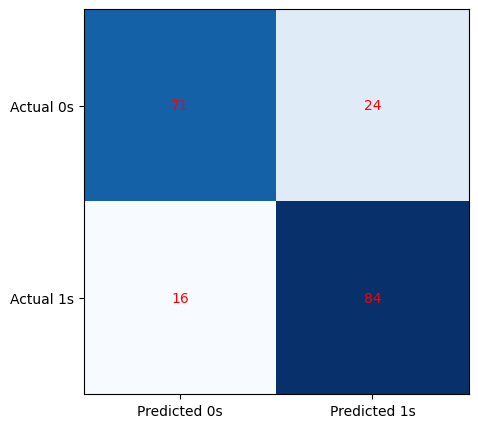

Metrics computed from a confusion matrix (Test ratio 0.2):
Accuracy:	 0.7948717948717948
Classification Error: 0.20512820512820518
Sensitivity/Recall:	 0.84
Specificity:	 0.7473684210526316
Precision:	 0.7777777777777778
False Positive Rate: 0.25263157894736843
#################################################################################################################################


                                        This is for 30% Test and 70% Train                                         

#################################################################################################################################
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
|age|trestbps|chol|fbs|restecg|thalach|exang|oldpeak| ca|thal|prediction|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
| 29|     130| 204|  0|      0|    202|    0|    0.0|  0|   2|       1.0|
| 34|     118| 182|  0|      0|    174|    0|    0.0|  0|   2|       1.0|
| 34|     118| 210|  0|      1|    192|    0|    0.7|  0|   2|       1.0|
| 35|     120| 198|  0|      1|    130|    1|    1.6|  0|   3|       0.0|
| 35|     122| 192|  0|      1|    174|    0|    0.0|  0|   2|       1.0|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
only showing top 5 rows

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|     1|       0.0|   41|
|     0|       0.0|  106|
|     1|       1.0|  116|
|     0|       1.0|   3

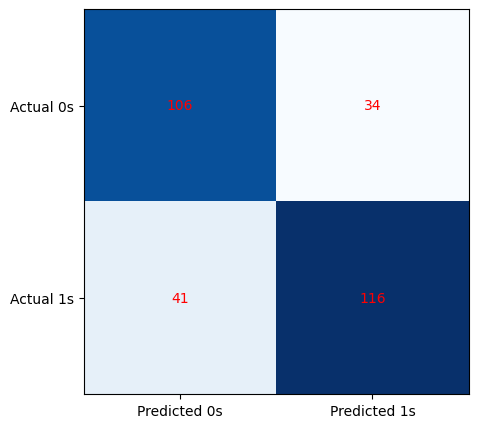

Metrics computed from a confusion matrix (Test ratio 0.3):
Accuracy:	 0.7474747474747475
Classification Error: 0.2525252525252525
Sensitivity/Recall:	 0.7388535031847133
Specificity:	 0.7571428571428571
Precision:	 0.7733333333333333
False Positive Rate: 0.24285714285714288
#################################################################################################################################


                                        This is for 35% Test and 65% Train                                         

#################################################################################################################################
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
|age|trestbps|chol|fbs|restecg|thalach|exang|oldpeak| ca|thal|prediction|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
| 34|     118| 182|  0|      0|    174|    0|    0.0|  0|   2|       1.0|
| 34|     118| 182|  0|      0|    174|    0|    0.0|  0|   2|       1.0|
| 34|     118| 210|  0|      1|    192|    0|    0.7|  0|   2|       1.0|
| 34|     118| 210|  0|      1|    192|    0|    0.7|  0|   2|       1.0|
| 35|     120| 198|  0|      1|    130|    1|    1.6|  0|   3|       0.0|
+---+--------+----+---+-------+-------+-----+-------+---+----+----------+
only showing top 5 rows

+------+----------+-----+
|target|prediction|count|
+------+----------+-----+
|     1|       0.0|   33|
|     0|       0.0|  126|
|     1|       1.0|  151|
|     0|       1.0|   3

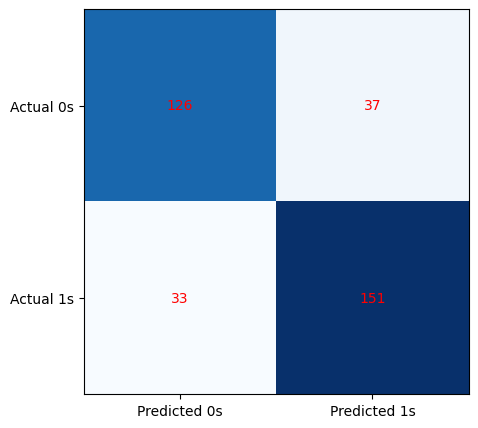

Metrics computed from a confusion matrix (Test ratio 0.35):
Accuracy:	 0.7982708933717579
Classification Error: 0.20172910662824206
Sensitivity/Recall:	 0.8206521739130435
Specificity:	 0.7730061349693251
Precision:	 0.8031914893617021
False Positive Rate: 0.22699386503067487


In [14]:
# Evaluate the model with different splits
evaluate_model(0.2, 0.8)  # 20% test, 80% train
evaluate_model(0.3, 0.7)  # 30% test, 70% train
evaluate_model(0.35, 0.65)  # 35% test, 65% train